# Extract FWHW and limit magnitude from SExtracted objects

In [ ]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits         # used to import fits files
from scipy.signal import find_peaks # used to find peaks of histograms

In [ ]:
# Open .cat file
FILENAME = "output.cat"
colnames = [
    "NUMBER", "X_IMAGE", "Y_IMAGE", "ALPHA_J2000", "DELTA_J2000",
    "MAG_AUTO", "MAGERR_AUTO", "FLUX_AUTO", "FLUX_RADIUS",
    "A_IMAGE", "B_IMAGE", "THETA_IMAGE", "ELLIPTICITY", "FWHM_IMAGE", "CLASS_STAR"
]

objects = pd.read_csv(FILENAME, delim_whitespace=True, comment='#',
                      names=colnames)

objects.head()

,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAGERR_AUTO,FLUX_AUTO,FLUX_RADIUS,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,FWHM_IMAGE,CLASS_STAR
0,1,2672.3767,420.8064,53.082746,-27.866566,21.7639,0.0004,312.2029,12.419,25.095,12.286,-77.02,0.510,14.66,0.029
1,2,2010.0853,232.0564,53.088987,-27.868141,20.4674,0.0001,1030.4770,19.579,19.788,17.841,60.72,0.098,22.14,0.029
2,3,1624.4827,156.7849,53.092621,-27.868769,22.5243,0.0003,154.9873,6.101,8.166,5.781,88.46,0.292,9.22,0.094
3,4,401.8863,114.4046,53.104144,-27.869124,22.1936,0.0003,210.1707,5.990,8.700,6.936,79.39,0.203,7.20,0.038
4,5,4267.3164,127.4607,53.067713,-27.869005,22.4799,0.0016,161.4545,17.119,48.048,27.301,-50.80,0.432,20.41,0.044


C:\Users\WBS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\WBS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


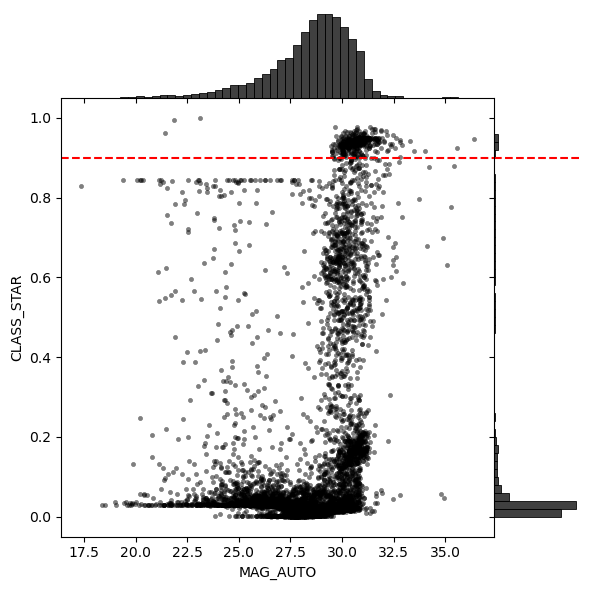

In [ ]:
# Plot MAG_AUTO and CLASS_STAR
# Zeropoint magnitude is 28.0, already set in source extractor
sns.jointplot(x=objects.MAG_AUTO[objects.MAG_AUTO < 90],
              y= objects.CLASS_STAR[objects.MAG_AUTO < 90],
              kind="scatter",
              color='black', edgecolor=None,
              space=0,
              s=10, alpha=.5,
              marginal_kws={'bins': 50, 'fill': True}).refline(
    y=0.9, color='red')

plt.show()

In [ ]:
##### From the .fits header, CDELT1 (Coordinate increment) is 8.3318730000584E-06 deg
# Therefore, the pixel scale is 3600 * 8.3318730000584E-06 arcsec/px

# Extract appropriate columns and remove non-point-like objects
# For FWHM, multiply by pixel scale
pixelScale = 3600 * 8.3318730000584E-06

FWHM = objects.FWHM_IMAGE[objects.CLASS_STAR > 0.9] * pixelScale
FWHM = FWHM[FWHM < 0.3]  # Remove outliers

# Report number of objects with CLASS_STAR > 0.9
print(f'Objects with CLASS_STAR > 0.9: {FWHM.shape[0]}')

Objects with CLASS_STAR > 0.9: 372


Peak of FWHM / Estimate seeing: 0.103 arcsec


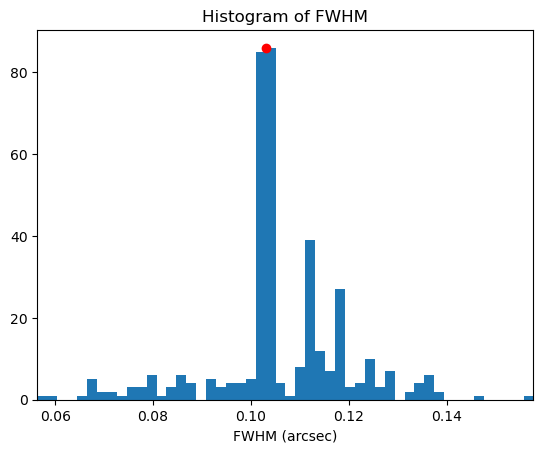

In [ ]:
# Plot histogram of FWHM and find peak
counts, bin_edges, _ = plt.hist(FWHM, bins=50)

# Find peak and Get estimated seeing
peaks, _ = find_peaks(counts, prominence=(60, None))
FWHM_lim = bin_edges[peaks]

# Plot everything else
print(f'Peak of FWHM / Estimate seeing: {FWHM_lim[0]:0,.3f} arcsec')
plt.scatter(FWHM_lim, counts[peaks], color='red')

plt.title('Histogram of FWHM')
plt.xlabel('FWHM (arcsec)')
plt.xlim(FWHM.min(), FWHM.max())

plt.show()

Now that the FWHM is found to be around 0.1 arcsec, let us find the magnitude limit.

In [ ]:
# Import fits file indicating BACKGROUND_RMS check files
FILENAME = 'bg_rms.fits'
hdul = fits.open(FILENAME)

hdul.info()

Filename: bg_rms.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (5001, 5001)   float32   


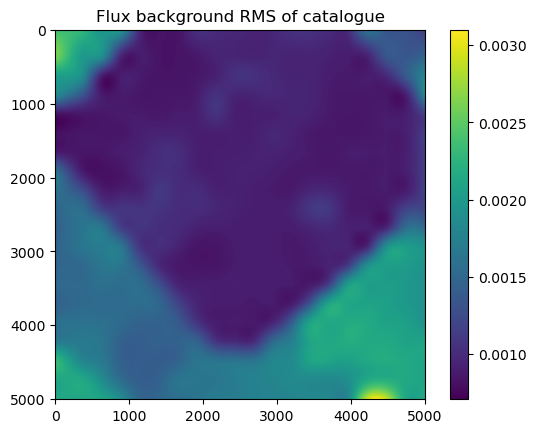

In [ ]:
# Convert fits file as 5001 x 5001 array and plot RMS
bg_rms = hdul[0].data

plt.imshow(bg_rms)
plt.title('Flux background RMS of catalogue')
plt.colorbar()

plt.show()

**So, why import background RMS?**

Simply put, the definition of root-mean-square is equivalent to the standard deviation if the average is 0. Which means that for a background-subtracted image (the average background being 0), the RMS is the standard deviation of background flux noise.

Meaning that the magnitude limit at 5 sigma is verily just the plot above, multiplied by 5. Notice that there are also *multiple* magnitude limits for each distinct regions seen from the plot above.

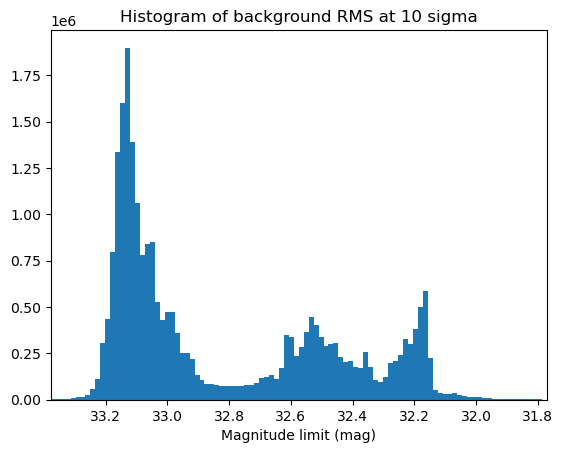

In [ ]:
# Evaluate magnitude limit
sigma = 10
ZP = 28.0
magLim = (bg_rms * sigma).flatten()  # Set flux limit
magLim = ZP - 2.5 * np.log10(magLim) # Convert to magnitude scale

# Plot
plt.hist(magLim, bins=100)

plt.title(f'Histogram of background RMS at {sigma} sigma')
plt.xlabel('Magnitude limit (mag)')
plt.xlim(magLim.max(), magLim.min())

plt.show()

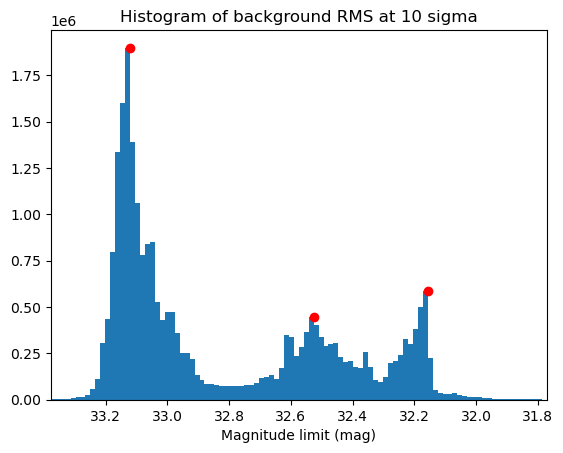

The three magnitude limits: [32.15686417 32.52642059 33.12092972]


In [ ]:
# Create histogram of magnitude limits
counts, bin_edges, _ = plt.hist(magLim, bins=100)

plt.title(f'Histogram of background RMS at {sigma} sigma')
plt.xlabel('Magnitude limit (mag)')
plt.xlim(magLim.max(), magLim.min())

# Find peaks and Get estimated magnitude limit
peaks, _ = find_peaks(counts, prominence=(0.3e6, 2e6))
magLim_modes = bin_edges[peaks]

# Plot modes
plt.scatter(magLim_modes, counts[peaks], color='red')
plt.show()

# Print mode bin values
print('The three magnitude limits:', magLim_modes)